# Load Processed Data

# GAN-type Model Architecture

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pickle # load variables.pkl
import cv2 # image preprocessing
import os

IMAGE_DIR = os.getcwd() + "/Datasets/words/"

# Step 1: Data collection - Prepare your labeled dataset
with open("./variables.pkl", "rb") as file:
    (
        filepaths_lst,
        words_lst,
        filepaths_dic,
        words_dic,
    ) = pickle.load(file)
print("Load Complete")

processed_image = []

# Step 3: process the images into normlized 100*100 grayscale images
for image_path in filepaths_dic.keys():
    # Load and preprocess the image
    image = cv2.imread(IMAGE_DIR+image_path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape
    print(f"Image dimensions: {width} x {height}")
    image = cv2.resize(image, (100, 100))  # Resize the image to a fixed size
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = image_tensor / 127.5 - 1.0  # Normalize pixel values between 0 and 1

    # Add the preprocessed image and its corresponding label to the lists
    processed_image.append(image)

Load Complete
Image dimensions: 27 x 51
Image dimensions: 213 x 48
Image dimensions: 70 x 50
Image dimensions: 166 x 78
Image dimensions: 126 x 61
Image dimensions: 382 x 73
Image dimensions: 173 x 72
Image dimensions: 441 x 100
Image dimensions: 147 x 79
Image dimensions: 208 x 42
Image dimensions: 294 x 59
Image dimensions: 174 x 63
Image dimensions: 237 x 70
Image dimensions: 65 x 70
Image dimensions: 72 x 54
Image dimensions: 113 x 63
Image dimensions: 281 x 46
Image dimensions: 80 x 59
Image dimensions: 64 x 35
Image dimensions: 339 x 96
Image dimensions: 91 x 74
Image dimensions: 302 x 65
Image dimensions: 177 x 59
Image dimensions: 431 x 54
Image dimensions: 9 x 10
Image dimensions: 320 x 68
Image dimensions: 252 x 56
Image dimensions: 190 x 63
Image dimensions: 134 x 57
Image dimensions: 153 x 71
Image dimensions: 221 x 48
Image dimensions: 58 x 29
Image dimensions: 428 x 54
Image dimensions: 78 x 32
Image dimensions: 167 x 61
Image dimensions: 319 x 94
Image dimensions: 191 x 

[ WARN:0@2533.667] global loadsave.cpp:248 findDecoder imread_('/Users/aoproudjiao/DS/ForgeNet/Datasets/words/a01/a01-000x/a01-000x-00-00.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

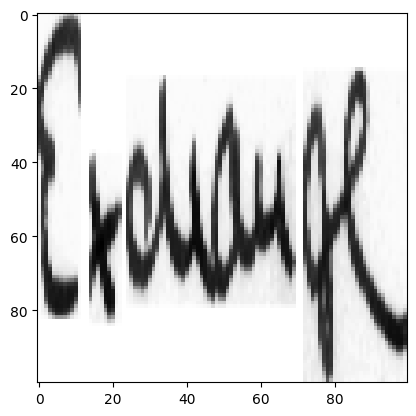

In [21]:
# test processed_image by plot out one processed image
import matplotlib.pyplot as plt
plt.imshow(processed_image[50], cmap="gray")

In [20]:
# Put processed images in new folder
import pickle
with open("./filtered_data/processed_images.pkl", "wb") as file:
    pickle.dump(processed_image, file)
print("Save Complete")

Save Complete


In [ ]:
training_dataset = 

In [1]:
# Step 4: Model selection
latent_dim = 100
text_dim = 128
image_dim = 100

# Generator model
generator_input = layers.Input(shape=(latent_dim + text_dim,))
x = layers.Dense(256)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Dense(512)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU()(x)
generator_output = layers.Dense(image_dim, activation='tanh')(x)
generator = tf.keras.Model(generator_input, generator_output)

# Discriminator model
discriminator_input = layers.Input(shape=(image_dim,))
x = layers.Dense(512)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
discriminator_output = layers.Dense(1, activation='sigmoid')(x)
discriminator = tf.keras.Model(discriminator_input, discriminator_output)

# Combined model
gan_input = layers.Input(shape=(latent_dim + text_dim,))
generated_image = generator(gan_input)
discriminator.trainable = False
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)

# Step 5: Data preparation
# Prepare your training dataset with input text and corresponding preprocessed images

# Step 6: Model training
batch_size = 32
epochs = 100
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

for epoch in range(epochs):
    for batch in range(len(training_dataset) // batch_size):
        # Generate random noise and text input
        noise = np.random.normal(size=(batch_size, latent_dim))
        text_input = get_random_text_input(batch_size)  # Custom function to get text input
        
        # Generate images from noise and text input
        generated_images = generator.predict([noise, text_input])

        # Combine real and generated images for the discriminator
        real_images = get_real_images(batch_size)  # Custom function to get real images
        combined_images = np.concatenate([real_images, generated_images])

        # Labels for real and generated images
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images)
            discriminator_loss = loss(labels, predictions)
        grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
        optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        # Train the generator (via the gan model)
        noise = np.random.normal(size=(batch_size, latent_dim))
        text_input = get_random_text_input(batch_size)  # Custom function to get text input
        labels = np.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            generated_images = generator([noise, text_input])
            predictions = discriminator(generated_images)
            generator_loss = loss(labels, predictions)
        grads = tape.gradient(generator_loss, generator.trainable_weights)
        optimizer.apply_gradients(zip(grads, generator.trainable_weights))

# Step 7: Model evaluation - Assess the performance of the trained model

# Step 8: Model fine-tuning - Fine-tune the model if necessary

# Step 9: Generation - Generate new images based on input text
input_text = "Hello, World!"
noise = np.random.normal(size=(1, latent_dim))
text_input = preprocess_text(input_text)  # Custom function to preprocess input text
generated_image = generator.predict([noise, text_input])
# Display or save the generated image



NameError: name 'training_dataset' is not defined

# VAE-type Model Architecture

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
latent_dim = 128  # Dimensionality of the latent space

# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        reconstructed = self.decoder(z)
        return reconstructed

vae = VAE(encoder, decoder)


## Loss Functions

In [ ]:
def reconstruction_loss(inputs, outputs):
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
    reconstruction_loss *= 28 * 28  # Image size
    return reconstruction_loss

def kl_divergence_loss(z_mean, z_log_var):
    # Kullback-Leiber Divergence Loss
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return kl_loss

def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction = reconstruction_loss(inputs, outputs)
    kl_divergence = kl_divergence_loss(z_mean, z_log_var)
    return reconstruction + kl_divergence

optimizer = keras.optimizers.Adam()
vae.compile(optimizer, loss=vae_loss)


# Train Model

In [ ]:
vae.fit(dataset, epochs=10, batch_size=64)

random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
generated_images = decoder(random_latent_vectors)

# Inference

In [ ]:
path_to_saved_model = '/content/scrabble-gan/res/out/big_ac_gan/model/generator_' + str(epochs)

# number of samples to generate
n_samples = 10
# your sample string
sample_string = 'machinelearning'

# load trained model
imported_model = tf.saved_model.load(path_to_saved_model)

# inference loop
for idx in range(1):
  fake_labels = []
  words = [sample_string] * 10
  noise = tf.random.normal([n_samples, latent_dim])
  
  # encode words
  for word in words:
    fake_labels.append([char_vec.index(char) for char in word])
  fake_labels = np.array(fake_labels, np.int32)

  # run inference process
  predictions = imported_model([noise, fake_labels], training=False)
  # transform values into range [0, 1]
  predictions = (predictions + 1) / 2.0

  # plot results
  for i in range(predictions.shape[0]):
    plt.subplot(10, 1, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    # plt.text(0, -1, "".join([char_vec[label] for label in fake_labels[i]]))
    plt.axis('off')
    plt.show()

# Post-processing

In [4]:
year = 1947
print(2023 - year)

76


In [14]:
import pandas as pd

data = [
    (0, 0, 50.800, 2.000),
    (12700, 2850, 50.825, 2.001),
    (25400, 5710, 50.851, 2.002),
    (38100, 8560, 50.876, 2.003),
    (50800, 11400, 50.902, 2.004),
    (76200, 17100, 50.952, 2.006),
    (89100, 20000, 51.003, 2.008),
    (92700, 20800, 51.054, 2.010),
    (102500, 23000, 51.181, 2.015),
    (107800, 24200, 51.308, 2.020),
    (119400, 26800, 51.562, 2.030),
    (128300, 28800, 51.816, 2.040),
    (149700, 33650, 52.832, 2.080),
    (159000, 35750, 53.848, 2.120),
    (160400, 36000, 54.356, 2.140),
    (159500, 35850, 54.864, 2.160),
    (151500, 34050, 55.880, 2.200),
    (124700, 28000, 56.642, 2.230)
]

df = pd.DataFrame(data)
display(df)
# Save the DataFrame as a CSV file
df.to_csv('data.csv', index=["N", "Lbf", "mm", "in."])

print("N       lbf       mm      in.")
for row in data:
    n, lbf, mm, inch = row
    #print(row[0])
    #print(f"{load:<7} {length:<8} {n:<8.3f} {lbf:<8.3f} {mm:<7.3f} {inch:<6.3f}")


,0,1,2,3
0,0,0,50.800,2.000
1,12700,2850,50.825,2.001
2,25400,5710,50.851,2.002
3,38100,8560,50.876,2.003
4,50800,11400,50.902,2.004
5,76200,17100,50.952,2.006
6,89100,20000,51.003,2.008
7,92700,20800,51.054,2.010
8,102500,23000,51.181,2.015
9,107800,24200,51.308,2.020


N       lbf       mm      in.
